In [1]:
from os import path as op
import pickle, ee, rasterio, rasterstats, folium 

import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rasterio.features import rasterize
from rasterstats.io import bounds_window

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, cohen_kappa_score, precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# 1. Data preparation

In [9]:
# read the training data polygons that has been created
training_vectors = gpd.read_file("training2019.geojson")
#14 15 17
#11

bbox = training_vectors.total_bounds
center = shp.geometry.box(bbox[0], bbox[1], bbox[2], bbox[3]).centroid

# show the 1st 5 lines
training_vectors

,id,label,geometry
0,1_0,2,POINT (7.49053 48.00599)
1,1_1,2,POINT (7.49396 48.01208)
2,1_2,2,POINT (7.49448 48.00243)
3,1_3,2,POINT (7.49928 48.00978)
4,1_4,2,POINT (7.50563 48.01426)
...,...,...,...
526,2_238,1,POINT (7.47955 48.69712)
527,2_239,1,POINT (7.47680 48.67899)
528,2_240,1,POINT (7.59216 48.61729)
529,2_241,1,POINT (7.55645 48.73337)


In [10]:
classes = np.unique(training_vectors.label)
class_dict = dict(zip(classes, range(1, len(classes) + 1)))
class_dict

{1: 1, 2: 2}

In [11]:
lst_raster = "stat_2019.tif"

In [12]:
X_raw_lst = []
y_raw_lst = []


with rasterio.open(lst_raster, 'r') as src:
    for (label, geom) in zip(training_vectors.label, training_vectors.geometry):
        
        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)
        # store our window information
        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        # rasterize the geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint8',
            all_touched=True
        ).astype(bool)
        
        # for each label pixel (places where the mask is true)
        label_pixels = np.argwhere(mask)
        
        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]
            one_x = np.nan_to_num(data, nan=1e-3)
            X_raw_lst.append(one_x)
            # add the label to y
            y_raw_lst.append(class_dict[label])

In [13]:
#Convert list to numpy array
X_lst = np.array(X_raw_lst)
y_lst = np.array(y_raw_lst)
# X_lst[:,0]

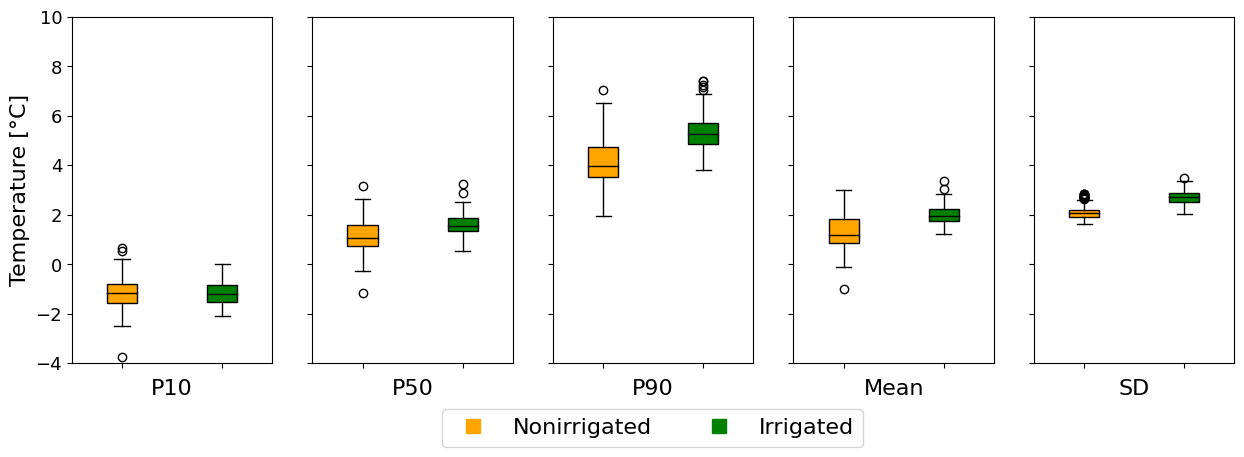

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_lst and y_lst are defined as in your code
X_lst = np.array(X_raw_lst)
y_lst = np.array(y_raw_lst)

X_data = []

x_labels = ['P10', 'P50', 'P90', 'Mean', 'SD']

# Iterate over columns 1 to 4
for i in range(0, 5):
    # Extract the ith column from X_raw_lst
    X_lst = np.array(X_raw_lst)[:, i]
    
    # Find indices where X_lst does not equal -999
    valid_indices = X_lst != -999
    
    # Filter X_lst and y_lst based on valid_indices
    X_valid = X_lst[valid_indices]
    y_valid = y_lst[valid_indices]
    
    # Separate X values based on y values
    X_y1 = X_valid[y_valid == 1]
    X_y2 = X_valid[y_valid == 2]
    
    # Append X_y1 and X_y2 to X_data
    X_data.append([X_y1, X_y2])

# Create boxplots for each column
fig, axs = plt.subplots(1, 5, figsize=(15, 4.5), sharey=True)

# Boxplot colors
box_colors = ['orange', 'green']

# legend_elements = [plt.Line2D([0], [0], color='orange', lw=8, label='Nonirrigated'),
#                    plt.Line2D([0], [0], color='green', lw=8, label='Irrigated')]

for i in range(5):
    bp = axs[i].boxplot(X_data[i], labels=['R', 'I'], patch_artist=True, widths=0.3)
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
    
    # Change color of the mean line to black
    for median in bp['medians']:
        median.set(color='black', linewidth=1)
    
    axs[i].set_xlabel(x_labels[i], fontsize=16)
    axs[i].set_xticklabels([], fontsize=16)
    axs[i].set_ylim([-4, 10])
    
    # Plot transparent data points
#     axs[i].scatter(np.random.normal(1, 0.1, len(X_data[i][0])), X_data[i][0], color='red', alpha=0.5)
#     axs[i].scatter(np.random.normal(2, 0.1, len(X_data[i][1])), X_data[i][1], color='blue', alpha=0.5)

# Set y-label outside the loop
# axs.set_ylim([-4, 8])
axs[0].set_ylabel('Temperature [°C]', fontsize=16)
axs[0].tick_params(axis='y', labelsize=13)

plt.legend(handles=[plt.Line2D([0], [0], marker='s', color='orange', lw=0, markersize=10, label='Nonirrigated'),
                     plt.Line2D([0], [0], marker='s', color='green', lw=0, markersize=10, label='Irrigated')],
           loc='upper right', bbox_to_anchor=(-0.8, -0.1), fontsize=16, ncol=2)

# fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.02, 0.91), fontsize=12)

plt.savefig('box_plot19.png', dpi=300, bbox_inches='tight')
plt.show()


In [426]:
X_train, X_test, y_train, y_test = train_test_split(X_lst, y_lst, test_size = 0.2, random_state = 0, stratify = y_lst)

In [427]:
X_train.shape

(574, 5)

In [428]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{1: 0.0029069767441860465, 2: 0.004347826086956522}

In [429]:
y_test

array([1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2,
       2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1,
       2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2,
       2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2])

# 2. Train the model

In here, we use an architecture from random forest classification method. So, we skip this step where it should elaborate on building an architecture.

In [430]:
# initialize a RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=200,
    class_weight=class_weight_dict,
    max_depth=10,
    n_jobs=-1,
    verbose=1,
    random_state=0)

In [431]:
# fit the model to the data (training)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(class_weight={1: 0.0029069767441860465,
                                     2: 0.004347826086956522},
                       max_depth=10, n_estimators=200, n_jobs=-1,
                       random_state=0, verbose=1)

In [432]:
print(X_train[:,0].shape)

(574,)


In [433]:
# predict on X_test to evaluate the model
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [434]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9236111111111112


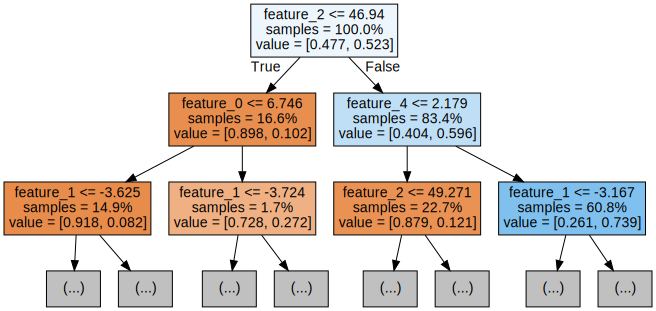

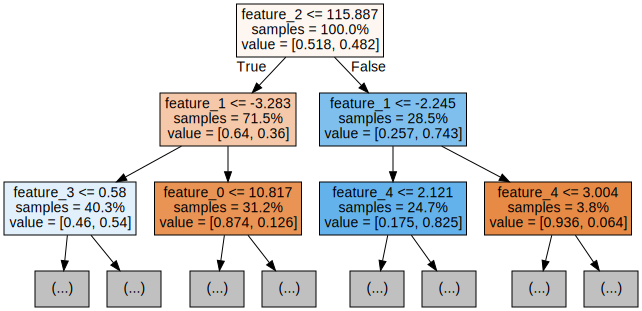

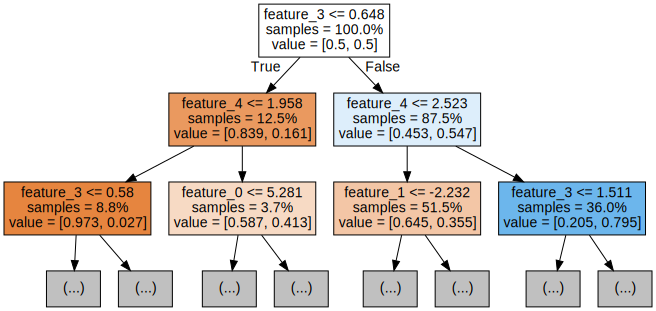

In [435]:
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

for i in range(3):
    tree = clf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=feature_names,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [436]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(clf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 226 out of 226 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 226 out of 226 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 226 out of 226 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 226 out of 226 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend L

[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  86 out of  86 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 254 out of 254 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 254 out of 254 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 239 out of 254 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight={1: 0.0029069767441860465,
                                                                  2: 0.004347826086956522},
                                                    max_depth=10,
                                                    n_estimators=200, n_jobs=-1,
                                                    random_state=0, verbose=1),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027502FB7040>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027504D67580>})

In [437]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 11, 'n_estimators': 122}


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 122 out of 122 | elapsed:    0.0s finished


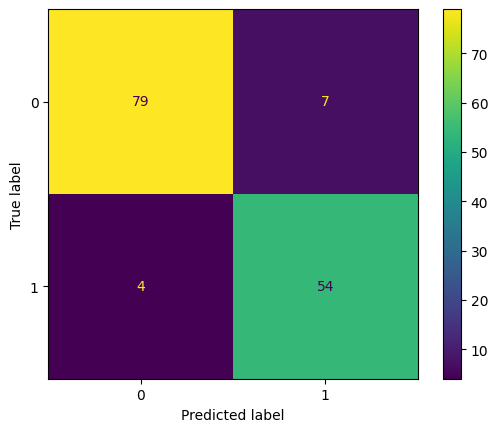

In [438]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [439]:
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')  # or 'micro', 'weighted' depending on your needs
kappa = cohen_kappa_score(y_test, y_pred)
p0 = np.mean(y_test == y_pred)

print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("Cohen's Kappa:", kappa)
# print("p0:", p0)
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))

Accuracy: 0.9236111111111112
(0.9185265652775034, 0.9248195669607057, 0.921237133906817, None)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


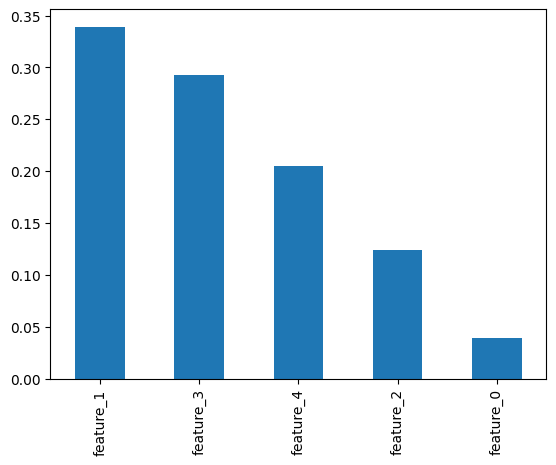

In [65]:
# Assuming X_train is a NumPy array
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

# Create a series containing feature importances from the model and feature names
feature_importances = pd.Series(best_rf.feature_importances_, index=feature_names).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()
plt.show()

# 3. Classify the irrigated map over the full image

In [67]:
import numpy as np
import rasterio

new_image = "stat_2018_4.tif"

# specify the output-5
output_image = "classification2018_9.tif"

with rasterio.open(new_image, 'r') as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.float32,
        count=1,
        nodata=float(-999)
    )

    with rasterio.open(output_image, 'w', **profile) as dst:
        # perform prediction on each small image patch to minimize required memory
        patch_size = 500

        for i in range((src.shape[0] // patch_size) + 1):
            for j in range((src.shape[1] // patch_size) + 1):
                # define the pixels to read (and write) with rasterio windows reading
                window = rasterio.windows.Window(
                    j * patch_size,
                    i * patch_size,
                    # don't read past the image bounds
                    min(patch_size, src.shape[1] - j * patch_size),
                    min(patch_size, src.shape[0] - i * patch_size))

                # read the image into the proper format
                data = src.read(window=window)

                # adding indices if necessary
                img_swp = np.moveaxis(data, 0, 2)
                img_flat = img_swp.reshape(-1, img_swp.shape[-1])

                # create a masked array with no data values
                img_masked = np.ma.masked_equal(img_flat, -999)

                # skip empty inputs
                if img_masked.mask.all():
                    continue

                # predict only on valid pixels
                img_preds = clf.predict(img_masked[~img_masked.mask].reshape(-1, img_swp.shape[-1]))

                # add the prediction back to the valid pixels
                output = np.zeros(img_flat.shape[0])
                output[~img_masked.mask[:, 0]] = img_preds.flatten()

                # resize to the original image dimensions
                output = output.reshape(*img_swp.shape[:-1])

                # create our final mask
                mask = (~img_masked.mask[:, 0]).reshape(*img_swp.shape[:-1])

                # write to the final files
                dst.write(output.astype(rasterio.uint8), 1, window=window)
                dst.write_mask(mask, window=window)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      |